In [1]:
using Revise
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
import ProgressMeter

In [2]:
import ReactiveMP.messageout

In [15]:
include("helpers/data.jl")
include("helpers/form_constraint.jl")

In [14]:
function NN(y_,u_,θ)
    x = [y_;u_]'*θ
    1/(1+exp(-x))
end

NN (generic function with 1 method)

In [16]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, dim, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u)
    # initialize variables
    h       = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))}  
    y       = datavar(Float64, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end]
    
    sigmoid_out = [NN(y_prev[i], u[i], params_f) for i in 1:n]

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(w_prior[1], w_prior[2]) where {q=MeanField()}
    
    # specify transformed latent value
    
    AR_meta = ARMeta(Multivariate, dim, ARsafe())
    
    h_prev = h_0
    
    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)
    for t in 1:n

        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}

        y_lat_1[t] ~ Flow(h[t]) where { meta = Flow_meta }
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dim))
        y_lat_3[t] ~ y_lat_2[t] + sigmoid_out[t]

        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_3[t], w)
        
        h_prev = h[t]
    end

    # return variables
    return h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [17]:
function nonlinear_max_inference(observations,observations_prev, controls, model_flow::FlowModel, params; 
                                 h_prior=(zeros(dim), diageye(dim)), w_prior=(1.0, 1e3), dim=2, vmp_its = 10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_nodes) = nonlinear_max(n, dim, model_flow, params, h_prior, w_prior,
                                                                            observations_prev, controls,
                                                                            options = (limit_stack_depth = 500, ))
    
    h_post = getmarginals(h)
    
    h_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(h_post, (x) -> copyto!(h_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    
    
    # return the marginal values
    return fe_buffer, h_buffer, w_buffer, y_out_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [18]:
# specify flow model
dim = 2
model_flow = FlowModel(dim,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [19]:
n_samples = 100
controls_ = collect(1:n_samples+10)
order_y, order_u, order_e = 10, 10, 10
y_lat, y_obs, h = generate_data(n_samples, narx, Dict(:order_y=>order_y, :order_u=>order_u, :order_e=>order_e),
                                                 Dict(:er_var=>1e-1, :u=>controls_))

(Any[0.06283835903050715, 0.4682086969961583, 0.26256200142869235, 0.6144869733489511, 0.43767024894530854, 0.5453399025876062, 0.24002893199423916, 0.019415264106498596, -0.7412653174204267, -0.21324908637979406  …  -0.35676154108189323, -0.015516971771176946, 0.16264461240882075, 0.29709448886095, 0.5475397684339669, 0.648364517327012, -0.2717213859493148, -0.20590893377346778, -0.5530456802258094, 0.17654112050299575], [-0.6730511373017314, -1.0116340239177775, -0.08929337677420802, 0.48087685524483376, 0.2646973134858417, 1.389756185559155, 2.5839919300166576, 1.7931619335594662, 0.7829355228995433, -0.6749636173316884  …  -0.9555595434858526, -0.16558121137275253, 0.005491362455587068, 0.5218073103588805, 0.5682378960315824, 0.30120129902361903, -0.017342833635033528, -0.43559423228339134, -0.256466257119595, 0.0832914499580941], [-0.26941065008068954, -1.6435578252371268, 0.41362030655405885, -0.9710687824538679, 0.7002319597420414, -0.2963679282730866, -1.0766882948790577, 0.995

In [20]:
observations_prev = y_obs[1:end-1]
observations = y_obs[2:end];
controls = controls_[order_u:end];

In [21]:
train_size = 80
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

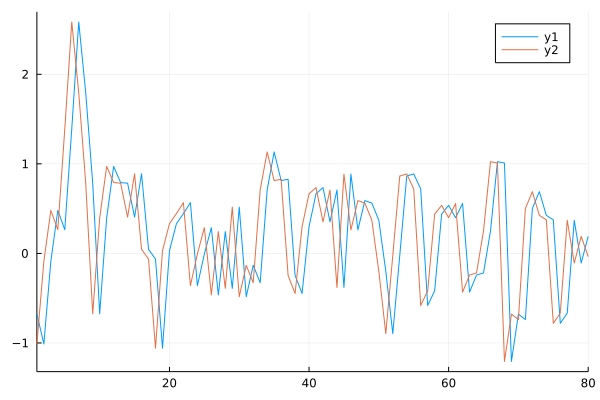

In [22]:
plot(X_train, xlims=(1, train_size))
plot!(Y_train, xlims=(1, train_size))

In [23]:
function FE(params)
    fe, h, w, y_out = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, dim=2, vmp_its=50)
    return fe[end]
end;

In [24]:
param_len = nr_params(model_flow)

12

In [25]:
fe, h, w, y_out = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, randn(param_len+2), dim=2, vmp_its=100);

MethodError: MethodError: no method matching nonlinear_max_inference(::Vector{Float64}, ::Vector{Float64}, ::Vector{Int64}, ::FlowModel{8, Tuple{ReactiveMP.AdditiveCouplingLayerEmpty{Tuple{ReactiveMP.PlanarFlowEmpty{1}}}, PermutationLayer{Int64}, ReactiveMP.AdditiveCouplingLayerEmpty{Tuple{ReactiveMP.PlanarFlowEmpty{1}}}, PermutationLayer{Int64}, ReactiveMP.AdditiveCouplingLayerEmpty{Tuple{ReactiveMP.PlanarFlowEmpty{1}}}, PermutationLayer{Int64}, ReactiveMP.AdditiveCouplingLayerEmpty{Tuple{ReactiveMP.PlanarFlowEmpty{1}}}, PermutationLayer{Int64}}}, ::Vector{Float64}; dim=2, vmp_its=100)
Closest candidates are:
  nonlinear_max_inference(::T, ::T, !Matched::T, ::FlowModel, ::Any; h_prior, w_prior, dim, vmp_its) where T<:Vector{Float64} at /Users/apodusenko/Documents/Julia/CDC-2022/ar-flow-deterministic.ipynb:1

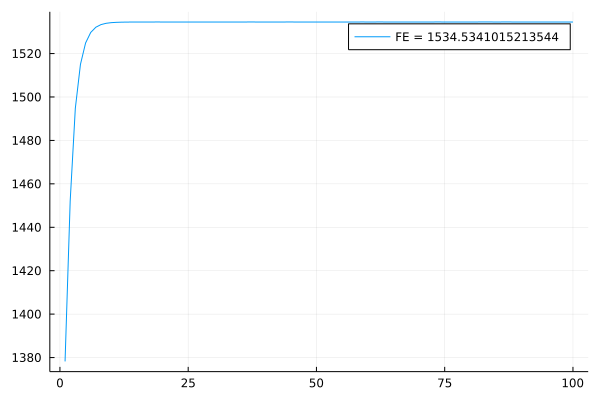

In [195]:
gr()
plot(fe, label="FE = $(fe[end])")

In [196]:
using Optim
res = optimize(FE, randn(nr_params(model_flow)+2), LBFGS(), Optim.Options(store_trace = true, show_trace = true), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     1.495855e+03     8.071983e+01
 * time: 0.00014901161193847656
     1     1.406138e+03     2.450535e+01
 * time: 32.74354290962219
     2     1.405060e+03     2.807942e+01
 * time: 318.41786098480225
     3     1.403249e+03     3.095926e+01
 * time: 629.6523380279541
     4     1.403191e+03     3.109593e+01
 * time: 960.9227089881897
     5     1.402914e+03     3.116446e+01
 * time: 1275.6955869197845
     6     1.401292e+03     3.096984e+01
 * time: 1596.065759897232
     7     1.401292e+03     3.096984e+01
 * time: 2014.7260229587555


 * Status: success

 * Candidate solution
    Final objective value:     1.401292e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.10e+01 ≰ 1.0e-08

 * Work counters
    Seconds run:   2015  (vs limit Inf)
    Iterations:    7
    f(x) calls:    390
    ∇f(x) calls:   390


In [197]:
inf_params = Optim.minimizer(res)
FE(inf_params)

1410.1782001349693

In [198]:
inf_params = Optim.minimizer(res)


fe, h, w = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, dim=2, vmp_its=100);

In [232]:
inv(mean(w))

5.0488922358453285

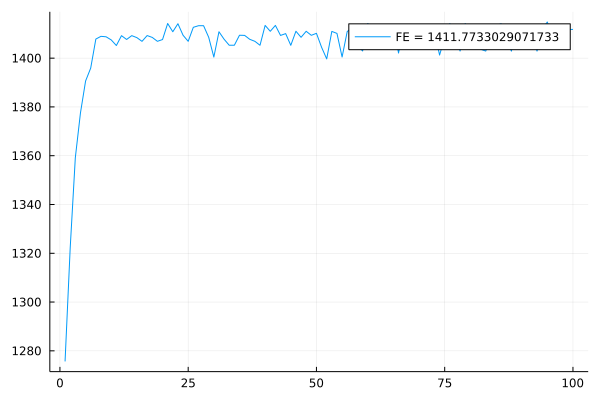

In [200]:
plot(fe, label="FE = $(fe[end])")

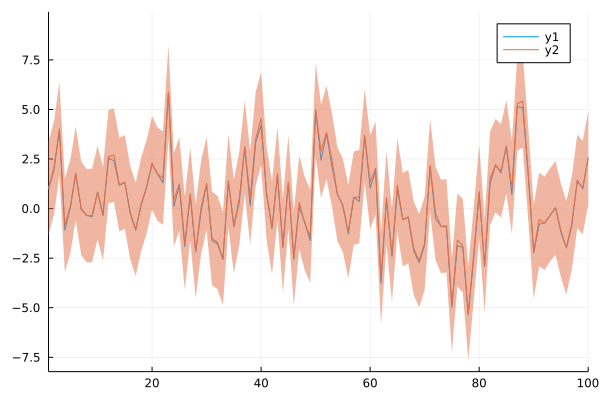

In [207]:
my, vy = mean.(y_out), cov.(y_out)
plot(Y_train, xlims=(1, 100))
plot!(my, ribbon=sqrt.(vy))

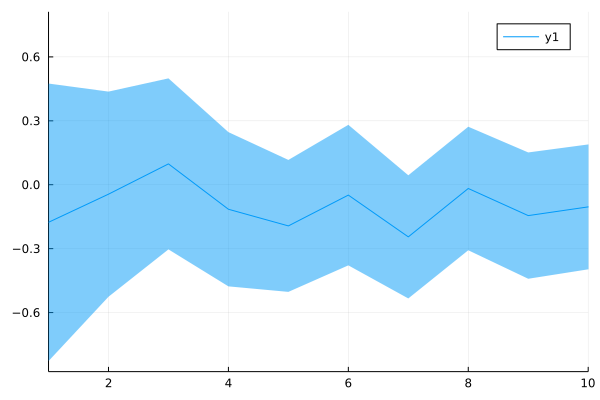

In [211]:
mh, vh = mean.(h), cov.(h)
plot(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(1, 10))
# plot!(last.(mh), ribbon=sqrt.(last.(vh)), xlims=(1, 10))

In [212]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction(dim, model_flow::FlowModel, params, h_prior, w_prior, y_prev, u)
    # initialize variables
    y_pred       = datavar(Float64)
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end]

    sigmoid_pred = sigmoid(y_prev, u, params_f)
    # @show sigmoid_pred

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ MvNormalMeanPrecision(h_prior[1], h_prior[2])
    θ   ~ MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim))
    w   ~ GammaShapeRate(w_prior[1], w_prior[2]) where {q=MeanField()}
    
    # specify transformed latent value
    
    AR_meta = ARMeta(Multivariate, dim, ARsafe())
    
    h_prev = h_0
    # specify observations
    
    ar_node, h ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
    
    y_lat_1 ~ Flow(h) where { meta = Flow_meta }
    
    y_lat_2 ~ dot(y_lat_1, ones(dim))
    
    y_lat_3 ~ y_lat_2 + sigmoid_pred

    y_node, y ~ NormalMeanPrecision(y_lat_3, w)
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred
end

nonlinear_max_prediction (generic function with 2 methods)

In [215]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(dim), diageye(dim)), w_prior=(1.0, 1e3), dim=2, vmp_its = 10) where T<:Float64

    # define model
    model, (h, θ, w, y_lat_1, y_lat_2, y_lat_3, y, y_node, y_pred) = nonlinear_max_prediction(dim, model_flow, params, h_prior, w_prior,
                                                                                              observation_prev, control,
                                                                                              options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    y_out_buffer = nothing
    w_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y_lat_2), (x) -> y_pred_buffer = x)
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        setmarginal!(θ, MvNormalMeanPrecision(zeros(dim), ReactiveMP.huge*diageye(dim)))
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, w_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 2 methods)

In [216]:
(mean(h[end]), precision(h[end]))
(shape(w), rate(w))
# inv(mean(w))

(401.0, 2024.6057865739767)

In [243]:
predictions = []
# for i in 1:length(X_test)
h_pred = (mean(h[end]), precision(h[end]))
w_pred = (shape(w), rate(w))
rw = []
for i in 1:length(X_test)
    fe, h_pred_, w_pred_, y_pred = nonlinear_max_prediction(X_test[i], 0.0, model_flow, inf_params, h_prior=h_pred, w_prior=w_pred, dim=2, vmp_its=100)
    push!(predictions, y_pred)
    h_pred = (mean(h_pred_), precision(h_pred_))
    # w_pred = (shape(w_pred_), rate(w_pred_))
    push!(rw, [mean(h_pred_)[1], cov(h_pred_)[1]])
end

In [244]:
mx, vx = mean.(predictions), cov.(predictions)

([0.38336271818017964, 0.9414044823693427, 0.7074694918076714, 0.7312934597999953, 0.7297244497113046, 0.6518367766233905, 0.6613425707837768, 0.6715556527830315, 0.6971400605751595, 0.7518972406778652  …  0.8480096878033643, 0.8258600891525517, 0.775924262408626, 0.758734204441505, 0.797231837911647, 0.7214500027991306, 0.6220498031346503, 0.8311806561150769, 0.7136376299862596, 0.6907927667735773], [1.0154992108856586, 1.011972352579616, 1.0062676473114198, 1.0056972307982375, 1.004680506672499, 1.0048794840576445, 1.0044415788454062, 1.0046043358845809, 1.0044500697415126, 1.0044782709836628  …  1.0043382207101914, 1.004561396524485, 1.0045660178815785, 1.0045599971841062, 1.0044424191953918, 1.0047138383908343, 1.0045724298933858, 1.0041277374759345, 1.0048916713790128, 1.0043878333490766])

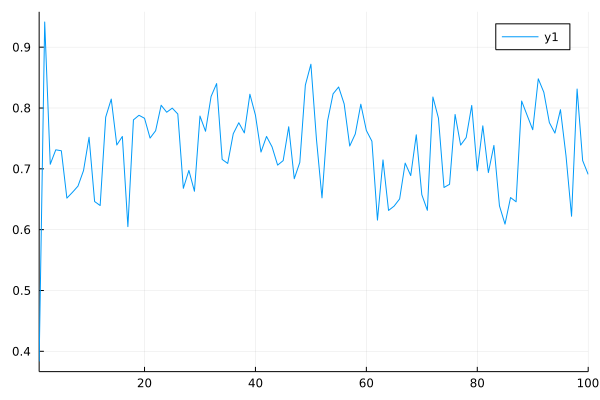

In [245]:
# plot(Y_test[1:100])
# plot!(mx, ribbon=sqrt.(vx), xlims=(1, 100))
plot(mx, xlims=(1, 100))

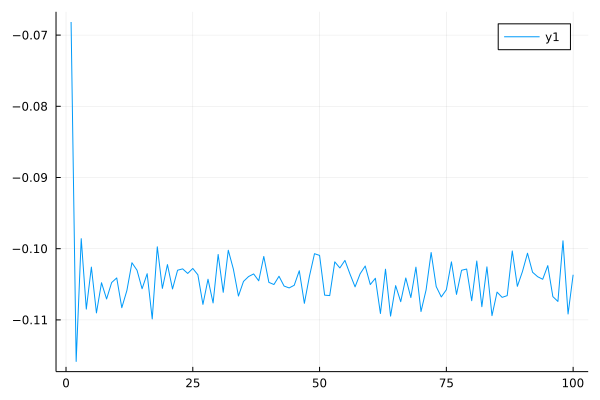

In [246]:
plot(first.(rw))